In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# ***Synthetic Data***

In [ ]:
num_projects = 50
num_consultants = 300

months = pd.date_range("2024-01-01", "2024-12-01", freq="MS")

projects = pd.DataFrame({
    "project_id": [f"P{i:03}" for i in range(1, num_projects+1)],
    "client_name": np.random.choice(
        ["NTT Data", "Infosys Ltd", "Wipro Pvt Ltd", "Accenture India"],
        num_projects
    ),
    "billing_rate": np.random.randint(90, 160, num_projects)
})

consultants = pd.DataFrame({
    "consultant_id": [f"C{i:03}" for i in range(1, num_consultants+1)]
})

# ***TIMESHEET GENERATION***

In [ ]:
timesheet_data = []

for month in months:
    for _ in range(1500):  # heavy volume
        timesheet_data.append({
            "consultant_id": np.random.choice(consultants["consultant_id"]),
            "project_id": np.random.choice(projects["project_id"]),
            "billing_month": month,
            "hours_logged": np.random.randint(140, 210)
        })

timesheets = pd.DataFrame(timesheet_data)

# Aggregate to project-month level
logged = timesheets.groupby(
    ["project_id", "billing_month"],
    as_index=False
).agg({"hours_logged": "sum"})

logged = logged.merge(projects, on="project_id", how="left")

***CREATE INVOICE TABLE***

In [ ]:
invoices = logged.copy()
invoices["hours_billed"] = invoices["hours_logged"]

***Failure scenarios***

In [ ]:
 #1️⃣ Late Timesheet Submission (15%)
late_indices = np.random.choice(
    invoices.index,
    size=int(len(invoices)*0.15),
    replace=False
)

invoices.loc[late_indices, "billing_month"] += pd.DateOffset(months=1)

# 2️⃣ Project Code Mismatch (7%)
mismatch_indices = np.random.choice(
    invoices.index,
    size=int(len(invoices)*0.07),
    replace=False
)

random_projects = np.random.choice(
    projects["project_id"],
    len(mismatch_indices)
)

invoices.loc[mismatch_indices, "project_id"] = random_projects

# 3️⃣ Partial Billing Cap (Contractual)
billing_cap = 8000

invoices["hours_billed"] = np.where(
    invoices["hours_billed"] > billing_cap,
    billing_cap,
    invoices["hours_billed"]
)

# 4️⃣ Client Naming Inconsistency
client_map = {
    "NTT Data": "NTT Ltd",
    "Infosys Ltd": "Infosys",
    "Wipro Pvt Ltd": "Wipro"
}

invoices["client_name"] = invoices["client_name"].replace(client_map)

# 5️⃣ Fully Reconciled Projects (25%)
perfect_indices = np.random.choice(
    invoices.index,
    size=int(len(invoices)*0.25),
    replace=False
)

invoices.loc[perfect_indices, "hours_billed"] = \
    logged.loc[perfect_indices, "hours_logged"]


***RECONCILIATION***

In [ ]:
recon = pd.merge(
    logged,
    invoices,
    on=["project_id", "billing_month"],
    how="outer",
    suffixes=("_logged", "_billed")
)

recon.fillna(0, inplace=True)

# IMPORTANT: Use correct suffixed column names
recon["revenue_logged"] = \
    recon["hours_logged_logged"] * recon["billing_rate_logged"]

recon["revenue_billed"] = \
    recon["hours_billed"] * recon["billing_rate_logged"]

recon["revenue_leakage"] = \
    recon["revenue_logged"] - recon["revenue_billed"]


***AGING LOGIC***

In [ ]:
# Ensure datetime format
recon["billing_month"] = pd.to_datetime(recon["billing_month"])

# For aging simulation, assume month-end date
recon["month_end"] = recon["billing_month"] + pd.offsets.MonthEnd(0)

# Simulate invoice date (for simplicity assume billed in billing_month)
recon["invoice_date"] = recon["month_end"]

# Aging days calculation
recon["aging_days"] = (
    recon["invoice_date"] - recon["month_end"]
).dt.days

# For rows where revenue_leakage > 0 (unbilled), simulate delay
recon.loc[recon["revenue_leakage"] > 0, "aging_days"] = np.random.choice(
    [15, 45, 75],
    size=len(recon.loc[recon["revenue_leakage"] > 0]),
    p=[0.5, 0.3, 0.2]
)

# Aging buckets
def aging_bucket(days):
    if days <= 30:
        return "0-30 Days"
    elif days <= 60:
        return "31-60 Days"
    else:
        return "60+ Days"

recon["aging_bucket"] = recon["aging_days"].apply(aging_bucket)

*ROI CALCULATION*

In [ ]:
# =====================================================
# 6B. ROI CALCULATION
# =====================================================

# Assume implementation cost
automation_cost = 50000  # one-time automation investment
analyst_hourly_cost = 50
manual_hours_previously = 1200
manual_hours_after = 300

manual_savings = (manual_hours_previously - manual_hours_after) * analyst_hourly_cost

gross_recovery = recon["revenue_leakage"].sum()

net_benefit = gross_recovery + manual_savings - automation_cost

roi_percentage = (net_benefit / automation_cost) * 100

print("\n===== ROI ANALYSIS =====")
print(f"Gross Revenue Recovery: ${gross_recovery:,.2f}")
print(f"Manual Audit Savings: ${manual_savings:,.2f}")
print(f"Automation Cost: ${automation_cost:,.2f}")
print(f"Net Benefit: ${net_benefit:,.2f}")
print(f"ROI %: {roi_percentage:.2f}%")



===== ROI ANALYSIS =====
Gross Revenue Recovery: $67,324,874.00
Manual Audit Savings: $45,000.00
Automation Cost: $50,000.00
Net Benefit: $67,319,874.00
ROI %: 134639.75%


***KPI SUMMARY***

In [ ]:
total_logged = recon["revenue_logged"].sum()
total_billed = recon["revenue_billed"].sum()
leakage = recon["revenue_leakage"].sum()
leakage_pct = (leakage / total_logged) * 100

print("\n===== ANNUAL REVENUE AUDIT SUMMARY =====")
print(f"Total Revenue Logged: ${total_logged:,.2f}")
print(f"Total Revenue Billed: ${total_billed:,.2f}")
print(f"Revenue Leakage: ${leakage:,.2f}")
print(f"Leakage %: {leakage_pct:.2f}%")


===== ANNUAL REVENUE AUDIT SUMMARY =====
Total Revenue Logged: $456,382,352.00
Total Revenue Billed: $389,057,478.00
Revenue Leakage: $67,324,874.00
Leakage %: 14.75%


***Data visualization***

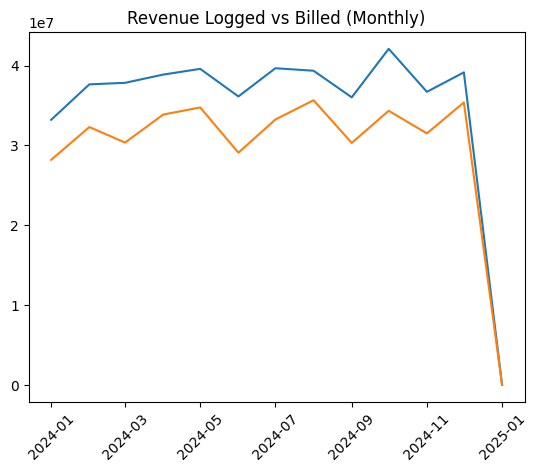

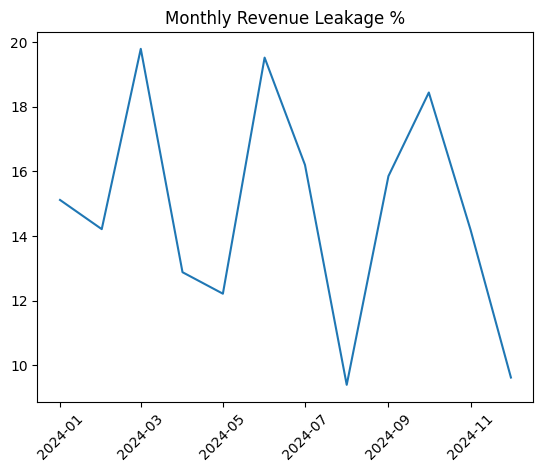

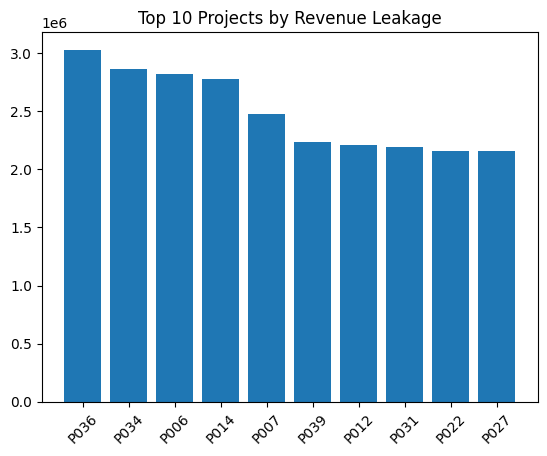

In [ ]:
monthly = recon.groupby("billing_month").agg({
    "revenue_logged": "sum",
    "revenue_billed": "sum",
    "revenue_leakage": "sum"
}).reset_index()

# Chart 1: Revenue Trend
plt.figure()
plt.plot(monthly["billing_month"], monthly["revenue_logged"])
plt.plot(monthly["billing_month"], monthly["revenue_billed"])
plt.title("Revenue Logged vs Billed (Monthly)")
plt.xticks(rotation=45)
plt.show()

# Chart 2: Monthly Leakage %
monthly["leakage_pct"] = (
    monthly["revenue_leakage"] / monthly["revenue_logged"]
) * 100

plt.figure()
plt.plot(monthly["billing_month"], monthly["leakage_pct"])
plt.title("Monthly Revenue Leakage %")
plt.xticks(rotation=45)
plt.show()

# Chart 3: Top 10 Projects by Leakage
project_leak = recon.groupby("project_id").agg({
    "revenue_leakage": "sum"
}).reset_index().sort_values(
    "revenue_leakage", ascending=False
).head(10)

plt.figure()
plt.bar(project_leak["project_id"], project_leak["revenue_leakage"])
plt.title("Top 10 Projects by Revenue Leakage")
plt.xticks(rotation=45)
plt.show()


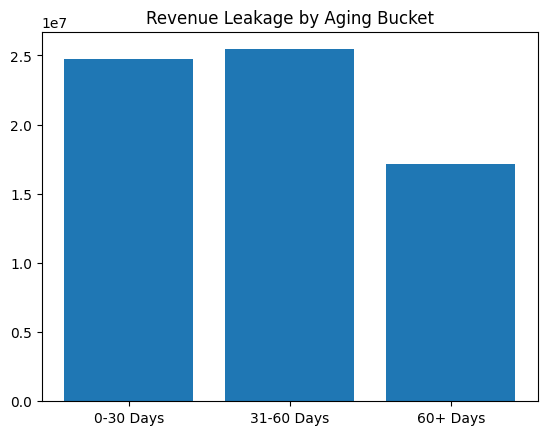

In [ ]:
# Chart: Aging Distribution
aging_summary = recon.groupby("aging_bucket")["revenue_leakage"].sum().reset_index()

plt.figure()
plt.bar(aging_summary["aging_bucket"], aging_summary["revenue_leakage"])
plt.title("Revenue Leakage by Aging Bucket")
plt.show()


In [ ]:
recon.to_csv("revenue_reconciliation_output.csv", index=False)